<a href="https://colab.research.google.com/github/pouyarahmti/Pytorch-Deep-Learning-Bootcamp/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Paper Replicaing

The goal of machine learning paper replicating is: turn a ML research paper into usable code.

In this notebook we are going to replicate Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929

In [1]:
import torch
import torchvision


print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 33.32 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [3]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


## 1. Get Data

We are going to use ViT architecture on our food vision mini data (Pizza, steak, sushi)

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and Dataloaders

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup


# Image Size
IMG_SIZE = 224 # Comes from table 3 of ViT paper

# Transform
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [64]:
# Batch Size
BATCH_SIZE = 32

# Create Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [65]:
## 2.3 Visualiz a single image

image_batch, label_batch = next(iter(train_dataloader))

# Get a single Image
img, label = image_batch[0], label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(2))

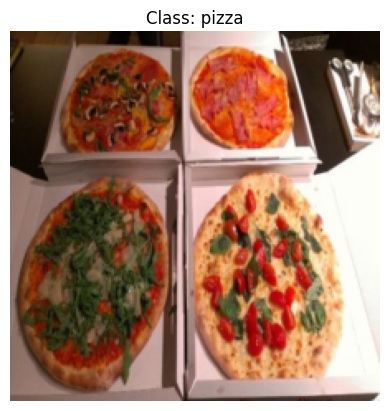

In [9]:
# plot the image with matplotlib
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {class_names[label]}")
plt.axis(False)
plt.show()

## 3. Replication ViT Model

Looking at a whole machine learning research paper can be iدtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

### 3.1 ViT pieces of Puzzle

* Figure 1: Visualize an overview of the ViT architecture
* 4 Equations: math equations which define the function of each layer/block
* Table 1/3: Different hyperparmeters for the architecture/training
* Text




#### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embeddings = Learnable representation (initialized with random numbers and improve over time)

#### 4 Equations

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-four-equations.png)

#### Table 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-table-1.png)


## 4. Equation 1: Split the data into patches and creating the class, patch and position embeddings

* Layers: Inputs -> Some Function -> Output

what's the input shape?

what's the output shape?

Input shape: (224, 224, 3) -> Single Image

Output shape:


Input Image: $H\times{W}\times{C}$
Output Image: ${N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = number of color channels
* P = Patch size
* N = number of patches = (heigth * width) / $P ^ 2$
* D = Constant latent vector size = embedding size (from table 1)

In [10]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

In [11]:
# Input shape
embedding_input_shape = (height, width, color_channels)

# Output shape
embedding_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

embedding_input_shape, embedding_output_shape

((224, 224, 3), (196, 768))

In [12]:
# Setup code to plot the whole image in patches

image_size = 224
patch_size = 16
num_patches = image_size / patch_size
assert image_size % patch_size == 0, "Image size must be divisible by patch size"


image_permuted = img.permute(1, 2, 0)

# print(f"Number of patches per row: {num_patches}\
#       \nTotal number of patches: {num_patches * num_patches}\
#       \nPatch size: {patch_size}x{patch_size}"
# )


# fig, axes = plt.subplots(nrows=image_size // patch_size,
#                          ncols=image_size // patch_size,
#                          figsize=(num_patches, num_patches),
#                          sharex=True,
#                          sharey=True)


# for i, patch_height in enumerate(range(0, image_size, patch_size)):
#     for j, patch_width in enumerate(range(0, image_size, patch_size)):
#         axes[i, j].imshow(image_permuted[patch_height:patch_height +patch_size,
#                                          patch_width:patch_width + patch_size, :],)

### 4.2 Creating image patches and embeddings with `torch.nn.Conv2d`

In [13]:
# Create Conv2d Layer to convert image to patches
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, # color channels
                                out_channels=768, # embedding size
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

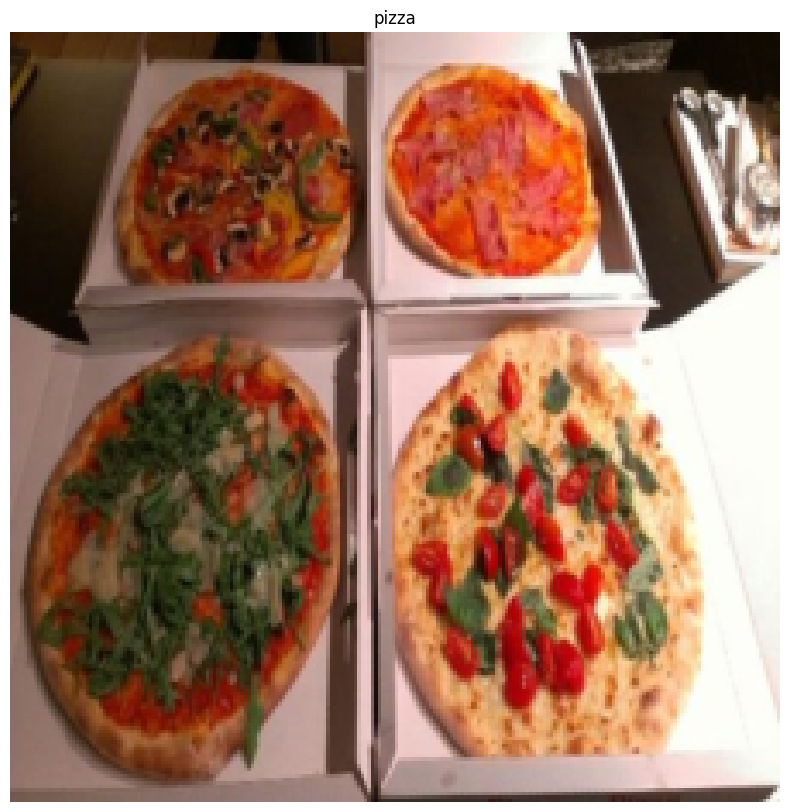

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [15]:
# Pass image through conv2d layer
image_conv = conv2d(img.unsqueeze(0)) # add batch dimension with unsqueeze => (batch_size, in_channels, height, width)
image_conv.shape

torch.Size([1, 768, 14, 14])

In [16]:
### 4.4 Flattening the patches


from torch import nn

flatter_layer = nn.Flatten(start_dim=2, end_dim=3)
flatter_layer

Flatten(start_dim=2, end_dim=3)

In [17]:
# Pass an image into flatten layer

image_flattened = flatter_layer(image_conv)
image_flattened.shape

torch.Size([1, 768, 196])

Image Original Shape: torch.Size([3, 224, 224])
Image Conv2d Shape: torch.Size([1, 768, 14, 14])
Image Flattened Shape: torch.Size([1, 768, 196])


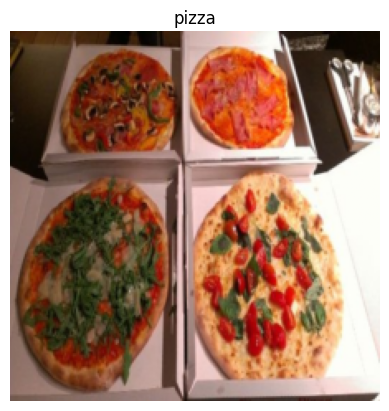

In [18]:
# Put everything together


plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)


print(f"Image Original Shape: {img.shape}")


# Conv2d
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
image_conv = conv2d(img.unsqueeze(0))
print(f"Image Conv2d Shape: {image_conv.shape}")

# Flatten
flatter_layer = nn.Flatten(start_dim=2, end_dim=3)
image_flattened = flatter_layer(image_conv)
print(f"Image Flattened Shape: {image_flattened.shape}")

In [19]:
# Rearrange the output of flatten layer to match ViT

image_flattened = image_flattened.permute(0, 2, 1)
image_flattened.shape

torch.Size([1, 196, 768])

In [20]:
# Visualize the output of the flatten layer

single_flattened_image_feature_map = image_flattened[ :, :, 0]


# Plot
plt.figure(figsize=(10, 10))
plt.imshow(single_flattened_image_feature_map.detach().numpy())
plt.axis(False)

(-0.5, 195.5, 0.5, -0.5)

In [21]:
# Combine layers into single layer

patch_size = 16


patch_embedding_layer = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=768,
              kernel_size=patch_size,
              stride=patch_size,
              padding=0),
    nn.Flatten(start_dim=2, end_dim=3)
)

patch_embedding_layer

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Flatten(start_dim=2, end_dim=3)
)

### 4.5 Turning the ViT Patch Embedding layer into a PyTroch Module

In [22]:
class PatchEmbedding(nn.Module):

  def __init__(self, patch_size=16, in_channels=3, embedding_dim=768):
    super().__init__()
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.embedding_dim = embedding_dim

    self.patcher = nn.Conv2d(in_channels = self.in_channels,
                             out_channels=self.embedding_dim,
                             kernel_size=self.patch_size,
                             stride=self.patch_size,
                             padding=0)
    self.flattener = nn.Flatten(start_dim=2, end_dim=3)


  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Image size must be divisible by patch size: {self.patch_size}"
    x_patched = self.patcher(x)
    x_flattened = self.flattener(x_patched)
    # Make sure output is aligned with the architecture (batch_size, number_of_patches, Embdedding dimension)
    return x_flattened.permute(0,2,1)

In [23]:

set_seeds()

# Creating an instance from PatchEmbedding Layer
patchify = PatchEmbedding(patch_size=patch_size,
                          in_channels=3,
                          embedding_dim=768
                          )

print(f"Image Original Shape: {img.shape}")
patch_embedded_img = patchify(img.unsqueeze(0)) # --> add batch dimension
print(f"Image Patch Embedded Shape: {patch_embedded_img.shape}")

Image Original Shape: torch.Size([3, 224, 224])
Image Patch Embedded Shape: torch.Size([1, 196, 768])


### 4.6 Creating the Class Token Embedding

Prepend a learnable class embedding to the start of Patch Embedding

In [24]:
batch_size = patch_embedded_img.shape[0]
embedding_dim = patch_embedded_img.shape[2]

batch_size, embedding_dim

(1, 768)

In [25]:
# Create a Class Token Embedding that matches Embedding Size (D)

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim),
                           requires_grad=True
                           )
class_token.shape

torch.Size([1, 1, 768])

In [26]:
patch_embedded_img_with_class_token = torch.cat((class_token, patch_embedded_img), dim=1)
patch_embedded_img_with_class_token.shape

torch.Size([1, 197, 768])

### 4.7 Creating Position Embeddings

In [27]:
# number of patches
number_of_patches = int((height * width) / patch_size ** 2)

# Embedding Dimension

embedding_dim = patch_embedded_img_with_class_token.shape[-1]

# Create 1D Learnable paramer
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1,
                                              embedding_dim),
                                  requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [28]:
# Add Position Embedding to Patch Embedding

patch_and_position_embedding = patch_embedded_img_with_class_token + position_embedding

print(f"Patch Embedding Shape: {patch_embedded_img_with_class_token.shape}")
print(f"Position Embedding Shape: {position_embedding.shape}")
print(f"Patch Embedding + Position Embedding Shape: {patch_and_position_embedding.shape}")

Patch Embedding Shape: torch.Size([1, 197, 768])
Position Embedding Shape: torch.Size([1, 197, 768])
Patch Embedding + Position Embedding Shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together

In [29]:
# 0. Set the seeds
set_seeds()

# 1. Patch Size
patch_size = 16

# 2. Print the shape of original image tensor and get the dimensions
print(f"Image Tensor Shape: {img.shape}")
height, width = img.shape[1], img.shape[2]

# 3. Get image and add batch dimension
x = img.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create Patch Embedding Layer
patch_embedding_layer = PatchEmbedding(patch_size=patch_size,
                                        in_channels=3,
                                        embedding_dim=768)

# 5. Get patche embedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape: {patch_embedding.shape}")


# 6. Create class token embeddings
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim),
                           requires_grad=True
                           )

# 7. Add Class token to patch_embeddings
patch_with_class_embedding = torch.cat((class_token, patch_embedding),
                                       dim=1)

print(f"Patch With Class Embedding Shape: {patch_with_class_embedding.shape}")


# 8. Create Position Embedding
number_of_patches = int((height * width) / patch_size ** 2)
embedding_dim = patch_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1,
                                              embedding_dim),
                                  requires_grad=True)

# 9. Add Position Embedding to Patch Embedding
patch_and_position_embedding = patch_with_class_embedding + position_embedding
print(f"Patch Embedding + Position Embedding Shape: {patch_and_position_embedding.shape}")

Image Tensor Shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch Embedding Shape: torch.Size([1, 196, 768])
Patch With Class Embedding Shape: torch.Size([1, 197, 768])
Patch Embedding + Position Embedding Shape: torch.Size([1, 197, 768])


## 5. Equation 2: MSA (Multi-Head Self Attention)

* Multi-Head Self Attention (MSA): which part of the sequence is focused on
  * in our case we have a sequence of patches and want to know which significantly related to each other
  * We want our neural network (ViT) to learn which patches are related to each other
  * MSA is a way to do that

* Layer Normalization: Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.

In [35]:
# MSA

class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768, # Hidden Size D (Embedding Dimension)
               num_heads: int = 12, # Number of heads (From table 1)
               attn_dropout: float = 0.0, # Attention Dropout
              ):

    super().__init__()


    # Creat the norm layer (LN)
    self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)


    # Create Multihead Attention Layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                            num_heads=num_heads,
                                            dropout=attn_dropout,
                                            batch_first=True) # is the batch first? -> (batch, seq, features) -> (batch, number_of_patches + 1, embedding_dim)



  def forward(self, x):
    x_norm = self.norm_layer(x)
    attn_output, _ = self.multihead_attn(query = x_norm,
                                    key = x_norm,
                                    value = x_norm,
                                    need_weights = False)
    return attn_output




In [38]:
# Create an instance of MultiHeadSelfAttentionBlock

msa_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                        num_heads=12,
                                        attn_dropout=0.0)




In [39]:
patched_image_through_msa = msa_block(patch_and_position_embedding)

print(f"Input Patched Image Shape: {patch_and_position_embedding.shape}")
print(f"Patched Image Through MSA Shape: {patched_image_through_msa.shape}")


Input Patched Image Shape: torch.Size([1, 197, 768])
Patched Image Through MSA Shape: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP)


* **MLP**: A quite broad term for a block with a series of layer(s), layers can be one hidden layer or multiple hidden layers
* Layers: fully_connected, dense, feed-forward, linear, are all often different names for a similar thing

MLP hidden size = 3072





In [41]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768, # Hidden Size D (Table1)
               mlp_dropout: float = 0.1, # Mlp Dropout
               mlp_hidden_dim: int = 3072 # Mlp Hidden Dimension
               ):
    super().__init__()


    # Create a Norm Layer
    self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create a Linear Layer
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_hidden_dim),
        nn.GELU(),
        nn.Dropout(p=mlp_dropout),
        nn.Linear(in_features=mlp_hidden_dim,
                  out_features=embedding_dim),
        nn.Dropout(p=mlp_dropout)
    )


  def forward(self, x):
    x_norm = self.norm_layer(x)
    return self.mlp(x_norm)


In [43]:
# Create an instance of MLPBlock

mlp_block = MLPBlock(embedding_dim=768,
                     mlp_dropout=0.1,
                     mlp_hidden_dim=3072)


patched_image_through_mlp = mlp_block(patched_image_through_msa)

print(f"Input Patched Image Shape: {patched_image_through_msa.shape}")
print(f"Patched Image Through MLP Block Shape: {patched_image_through_mlp.shape}")

Input Patched Image Shape: torch.Size([1, 197, 768])
Patched Image Through MLP Block Shape: torch.Size([1, 197, 768])


## 7. Transformer Encoder Block

The transformer encoder block is a combination of MSA and MLP blocks plus residual connections

* **Encoder**: Turn a sequence into a learnable representation
* **Decoder**: Go from learnable representation back to some sort of sequence
* **Residual Connections**: Add a layer(s) inputs to its subsequent output, this enable deeper network (Prevent weights from getting too small)

### 7.1 Create Custom Transformer Encoder Block

In [44]:
class TransformerEncoderBlock(nn.Module):

  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               attn_dropout: float = 0.0,
               mlp_dropout: float = 0.1,
               mlp_hidden_dim: int = 3072
               ):

    super().__init__()


    # Create an instance of MultiHeadSelfAttentionBlock
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                num_heads=num_heads,
                                                attn_dropout=attn_dropout)

    # Create an instance of MLPBlock
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                             mlp_dropout=mlp_dropout,
                             mlp_hidden_dim=mlp_hidden_dim)


  def forward(self, x):
    x = self.msa_block(x) + x # Residual/Skip Connection
    x = self.mlp_block(x) + x # Residual/Skip Connection
    return x


In [45]:
# Create an instance of TransformerEncoderBlock

transformer_encoder_block = TransformerEncoderBlock(embedding_dim=768,
                                                   num_heads=12,
                                                   attn_dropout=0.0,
                                                   mlp_dropout=0.1,
                                                   mlp_hidden_dim=3072)


patched_image_through_transformer_encoder = transformer_encoder_block(patched_image_through_mlp)

print(f"Input Patched Image Shape: {patched_image_through_mlp.shape}")
print(f"Patched Image Through Transformer Encoder Shape: {patched_image_through_transformer_encoder.shape}")

Input Patched Image Shape: torch.Size([1, 197, 768])
Patched Image Through Transformer Encoder Shape: torch.Size([1, 197, 768])


In [47]:
# Get Summary of Transformer Encoder Block

summary(transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create Transformer Encoder Layer with PyTorch Built-in Transformers

https://pytorch.org/docs/stable/nn.html#transformer-layers

In [49]:
# Created the same above architecture with `torch.nn.TransformerEncoderLayer`

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Embedding Dimension
                                                nhead=12, # Number of heads
                                                dim_feedforward=3072, # Mlp Hidden Dimension
                                                dropout=0.1, # Mlp Dropout
                                                activation="gelu", # GELU
                                                batch_first=True,
                                                norm_first=True,)

patched_image_through_torch_transformer = torch_transformer_encoder_layer(patched_image_through_mlp)

print(f"Input Patched Image Shape: {patched_image_through_mlp.shape}")
print(f"Patched Image Through Transformer Encoder Shape: {patched_image_through_torch_transformer.shape}")

Input Patched Image Shape: torch.Size([1, 197, 768])
Patched Image Through Transformer Encoder Shape: torch.Size([1, 197, 768])


In [51]:
summary(
    torch_transformer_encoder_layer,
    input_size=(1, 197, 768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8. Putting it all together to create Vision Transformer (ViT)

In [53]:
# Create ViT Class

class ViT(nn.Module):

  def __init__(self,
               img_size: int = 224, # Image Size
               in_channels: int = 3, # Input Channels
               patch_size: int = 16, # Patch Size
               num_transformer_layers: int = 12, # Number of Transformer Layers
               embedding_dim: int = 768, # Embedding Dimension
               num_heads: int = 12, # Number of Heads (Attention Heads)
               mlp_hidden_dim: int = 3072, # Mlp Hidden Dimension
               mlp_dropout: float = 0.1, # Mlp Dropout
               attn_dropout: float = 0.0, # Attention Dropout
               embedding_dropout: float = 0.0, # Embedding Dropout for Class & Position Embeddings
               num_classes: int = 1000,
               ):

    super().__init__()

    # Make assertions
    assert img_size % patch_size == 0, f"Image size {img_size} must be divisible by patch size {patch_size}"

    # Create number of patches
    self.num_patches = (img_size * img_size) // patch_size ** 2


    # Create Learnable Class Embedding
    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)


    # Create Learnable Position Embedding
    self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim),
                                        requires_grad=True)

    # Create Embedding DropOut
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create a Patch Embedding Layer
    self.patch_embedding_layer = PatchEmbedding(patch_size=patch_size,
                                                in_channels=in_channels,
                                                embedding_dim=embedding_dim)


    # Create Transformer Encoder Block
    self.transformer_encoder_block = nn.Sequential(
        *[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                  num_heads=num_heads,
                                  mlp_dropout=mlp_dropout,
                                  mlp_hidden_dim=mlp_hidden_dim,
                                  attn_dropout=attn_dropout)
          for _ in range(num_transformer_layers)])

    # Create Classification Head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )


  def forward(self, x):


    # Get Batch Size
    batch_size = x.shape[0]

    # Class Embedding
    class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means to infer the dimension

    # Patch Embedding
    x = self.patch_embedding_layer(x)

    # Concatenate Class & Patch Embeddings
    x = torch.cat((class_token, x), dim=1)

    # Add Position Embeddings
    x = x + self.position_embedding

    # Embedding Dropout
    x = self.embedding_dropout(x)

    # Transformer Encoder Block
    x = self.transformer_encoder_block(x)

    # Classification Head
    x = self.classifier(x[:, 0])

    return x




In [61]:
### 8.1 Get visual summary
vit = ViT(num_classes=len(class_names))

from torchinfo import summary

summary(
    ViT(num_classes=1000),
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding_layer)                     [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flattener)                                   [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder_block)                     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting Up Training code for ViT


### 9.1 Training

In [68]:
from going_modular.going_modular import engine

# set seeds
set_seeds(42)


# Set Loss Function
loss_fn = nn.CrossEntropyLoss()

# Set Optimizer
optimizer = torch.optim.Adam(vit.parameters(),
                             betas=(0.9, 0.999),
                             weight_decay=0.1,
                             lr=1e-3)

results = engine.train(
    model=vit,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10,
    device=device,)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.4708 | train_acc: 0.3906 | test_loss: 3.1566 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.2888 | train_acc: 0.2539 | test_loss: 2.4938 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.9476 | train_acc: 0.3320 | test_loss: 1.1414 | test_acc: 0.4413
Epoch: 4 | train_loss: 1.4614 | train_acc: 0.2773 | test_loss: 1.5625 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3958 | train_acc: 0.2969 | test_loss: 1.0786 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.1882 | train_acc: 0.3086 | test_loss: 1.4505 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1937 | train_acc: 0.4141 | test_loss: 2.2725 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4209 | train_acc: 0.2969 | test_loss: 1.7480 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3283 | train_acc: 0.2383 | test_loss: 1.0153 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2691 | train_acc: 0.2734 | test_loss: 1.2322 | test_acc: 0.2604


### 9.2 What's wrong?

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released). However, our results (so far) aren't as good.

There's a few reasons this could be but the main one is scale.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3)

The main thing our implementation is missing:

* Data - our setup uses far less data (225 vs millions)

Prevent Overfitting:
* Learning rate warmup - start with small learning rate and increase to base LR
* Learning rate decay - as your model get closer to convergance, lower the learning rate
* Gradient Clipping - Prevent gradients from getting too big

### 9.3 Plotting loss curves for our model

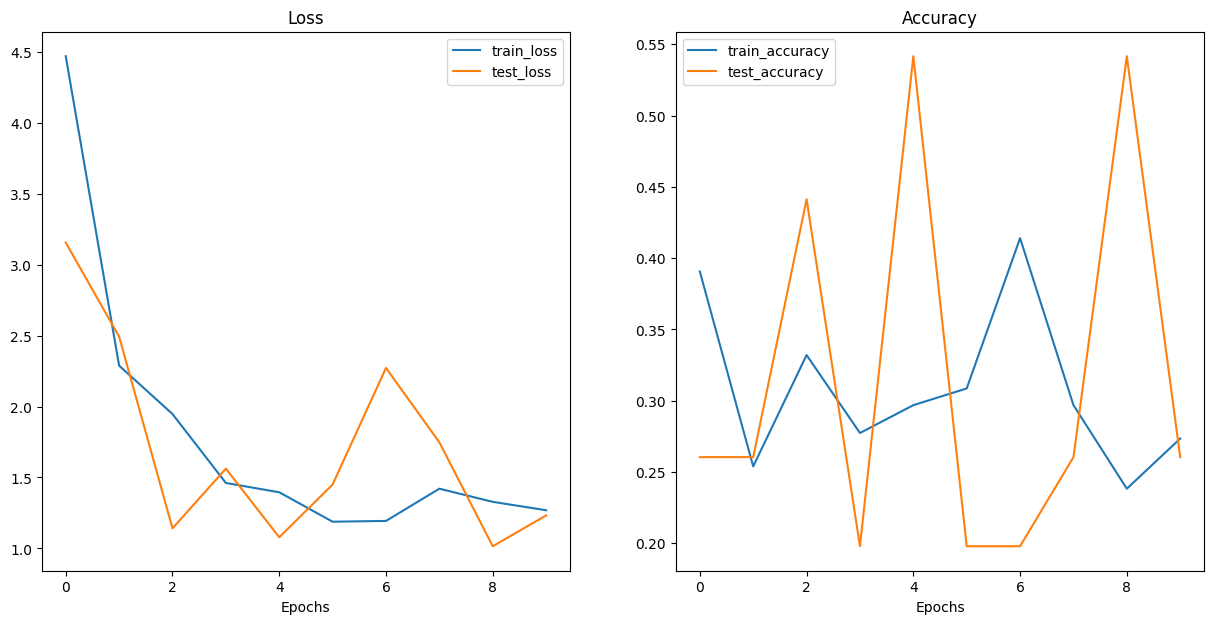

In [69]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pre-trained ViT model from `torchvision.models` to fine-tune

In [70]:
import torch
import torchvision

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

PyTorch Version: 2.5.1+cu121
Torchvision Version: 0.20.1+cu121


In [72]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [74]:
# Get Pre-trained weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT = Best pre-trained weights

# Setup a Vit model instance with pre-trained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 44.9MB/s]


In [75]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a